# 05. Model Evaluation

Notebook này đánh giá hiệu suất mô hình:
- Metrics (Accuracy, Precision, Recall, F1, ROC-AUC)
- Confusion Matrix
- ROC Curve
- Precision-Recall Curve
- So sánh models

In [1]:
# Import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

# Import project modules
import sys
from pathlib import Path

# Calculate project root by finding directory with config folder
current_path = Path().resolve()
project_root = current_path

# Find project root by looking for config/ directory
max_levels = 5
for _ in range(max_levels):
    if (project_root / 'config').exists() and (project_root / 'src').exists():
        break
    if project_root.parent == project_root:
        break
    project_root = project_root.parent
else:
    if 'notebooks' in str(current_path):
        project_root = current_path.parent

# Add src to Python path
src_path = project_root / 'src'
if src_path.exists():
    sys.path.insert(0, str(src_path))

from models.decision_tree import load_model as load_dt_model
from models.random_forest import load_model as load_rf_model
from models.train import predict, predict_proba
from evaluation.metrics import evaluate_model, print_classification_report
from evaluation.visualization import plot_confusion_matrix, plot_roc_curve, plot_precision_recall_curve

## 1. Load Models and Data

In [2]:
# Load models
dt_model = load_dt_model('decision_tree.pkl')
rf_model = load_rf_model('random_forest.pkl')

# Load test data
processed_dir = project_root / "data" / "processed"
X_test = pd.read_csv(processed_dir / "X_test.csv")
y_test = pd.read_csv(processed_dir / "y_test.csv").squeeze()

print("Models and data loaded successfully!")

Models and data loaded successfully!


## 2. Evaluate Decision Tree

In [3]:
# Evaluate Decision Tree
print("=== Decision Tree Evaluation ===\n")

dt_metrics = evaluate_model(dt_model, X_test, y_test)
print("Metrics:")
for metric, value in dt_metrics.items():
    print(f"{metric}: {value:.4f}")

# Predictions
y_pred_dt = predict(dt_model, X_test)
y_proba_dt = predict_proba(dt_model, X_test)[:, 1] if hasattr(dt_model, 'predict_proba') else None

# Classification report
print("\nClassification Report:")
print_classification_report(y_test, y_pred_dt)

=== Decision Tree Evaluation ===

Metrics:
accuracy: 0.8674
precision: 0.5793
recall: 0.5262
f1_score: 0.5514
roc_auc: 0.7281
pr_auc: 0.3782

Classification Report:
              precision    recall  f1-score   support

           0       0.91      0.93      0.92      2084
           1       0.58      0.53      0.55       382

    accuracy                           0.87      2466
   macro avg       0.75      0.73      0.74      2466
weighted avg       0.86      0.87      0.86      2466



## 3. Evaluate Random Forest

In [4]:
# Evaluate Random Forest
print("=== Random Forest Evaluation ===\n")

rf_metrics = evaluate_model(rf_model, X_test, y_test)
print("Metrics:")
for metric, value in rf_metrics.items():
    print(f"{metric}: {value:.4f}")

# Predictions
y_pred_rf = predict(rf_model, X_test)
y_proba_rf = predict_proba(rf_model, X_test)[:, 1] if hasattr(rf_model, 'predict_proba') else None

# Classification report
print("\nClassification Report:")
print_classification_report(y_test, y_pred_rf)

=== Random Forest Evaluation ===

Metrics:
accuracy: 0.9023
precision: 0.7640
recall: 0.5340
f1_score: 0.6287
roc_auc: 0.9171
pr_auc: 0.7207

Classification Report:
              precision    recall  f1-score   support

           0       0.92      0.97      0.94      2084
           1       0.76      0.53      0.63       382

    accuracy                           0.90      2466
   macro avg       0.84      0.75      0.79      2466
weighted avg       0.90      0.90      0.89      2466



## 4. Visualizations

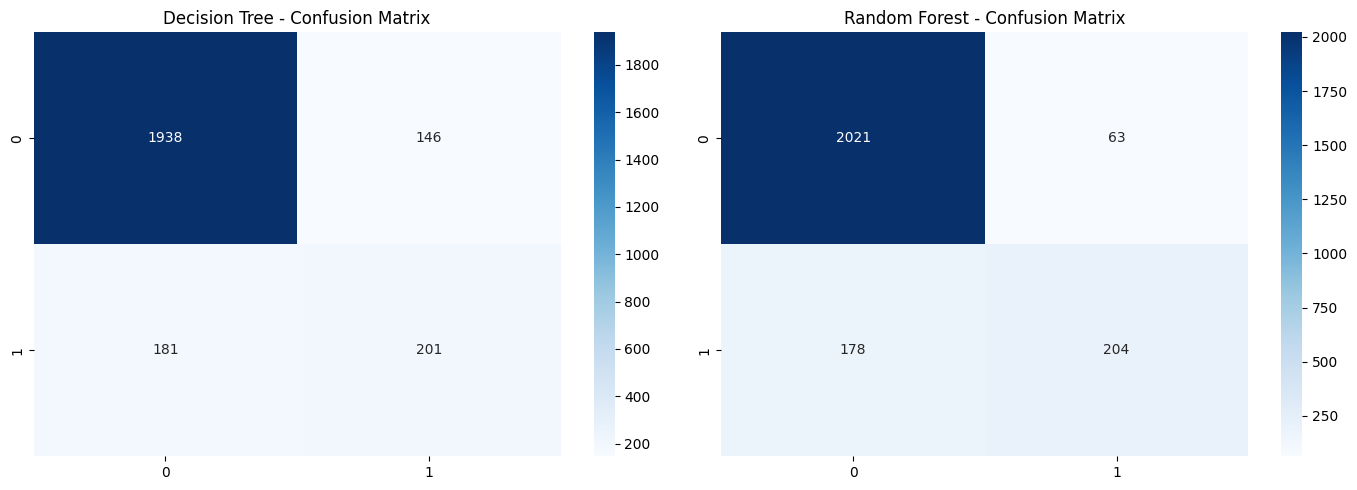

In [5]:
# Plot confusion matrices
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Decision Tree CM
from sklearn.metrics import confusion_matrix
cm_dt = confusion_matrix(y_test, y_pred_dt)
sns.heatmap(cm_dt, annot=True, fmt='d', ax=axes[0], cmap='Blues')
axes[0].set_title('Decision Tree - Confusion Matrix')

# Random Forest CM
cm_rf = confusion_matrix(y_test, y_pred_rf)
sns.heatmap(cm_rf, annot=True, fmt='d', ax=axes[1], cmap='Blues')
axes[1].set_title('Random Forest - Confusion Matrix')

plt.tight_layout()
plt.show()

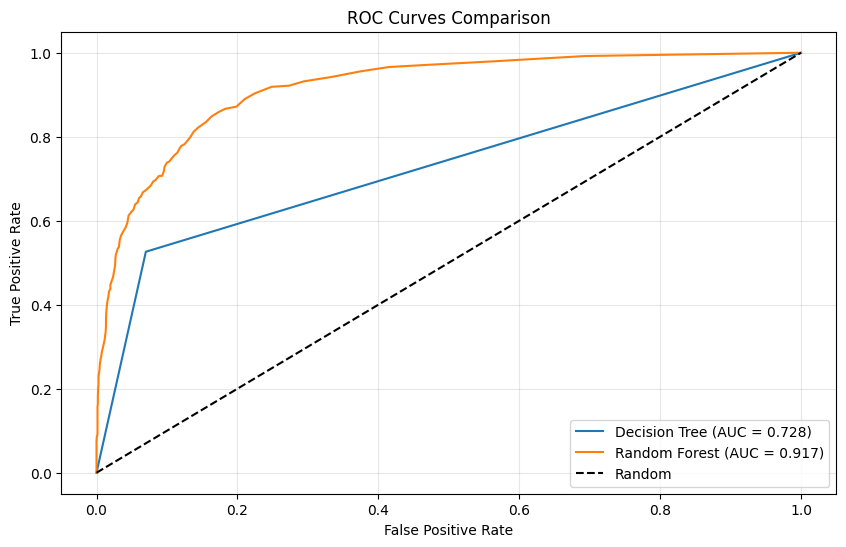

In [6]:
# ROC Curves
if y_proba_dt is not None and y_proba_rf is not None:
    from sklearn.metrics import roc_curve, auc
    
    fpr_dt, tpr_dt, _ = roc_curve(y_test, y_proba_dt)
    fpr_rf, tpr_rf, _ = roc_curve(y_test, y_proba_rf)
    
    plt.figure(figsize=(10, 6))
    plt.plot(fpr_dt, tpr_dt, label=f'Decision Tree (AUC = {auc(fpr_dt, tpr_dt):.3f})')
    plt.plot(fpr_rf, tpr_rf, label=f'Random Forest (AUC = {auc(fpr_rf, tpr_rf):.3f})')
    plt.plot([0, 1], [0, 1], 'k--', label='Random')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curves Comparison')
    plt.legend()
    plt.grid(alpha=0.3)
    plt.show()

## 5. Model Comparison

In [7]:
# Compare models
comparison = pd.DataFrame({
    'Decision Tree': dt_metrics,
    'Random Forest': rf_metrics
})
print("Model Comparison:")
print(comparison)

Model Comparison:
           Decision Tree  Random Forest
accuracy        0.867397       0.902271
precision       0.579251       0.764045
recall          0.526178       0.534031
f1_score        0.551440       0.628659
roc_auc         0.728060       0.917112
pr_auc          0.378187       0.720732
